<a href="https://colab.research.google.com/github/JuanSpecht/ML2021/blob/main/TP3/ML_TP3_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de máquina: Trabajo práctico 3, dataset Spotify

## Importo bibliotecas


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier                                                                                                                            

### Cargo el dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")

## Exploro las características del dataset 

In [ ]:
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1


In [ ]:
df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


## Elimino algunas columnas del dataset

* Voy a descartar la columna `Unnamed: 0` ya que es redundante con el índice del dataframe.
* También descarto `song_title`, ya que considero que en general el nombre de la canción no debería influir. Además no parece haber una manera de definir una métrica para los nombres de las canciones. Sólo puede aportar información si la canción a clasificar está también en el conjunto de entrenamiento, con lo cual ya sabríamos si le gusta o no.
* Por último, observando la distribución de los valores en la columna `artist` (que se muestra abajo) se ve que casi todas las canciones son de artistas distintos (la mayoría de los artistas aparecen 1 sola vez en el dataset), y el que más aparece lo hace 16 veces, por lo tanto, y con el mismo argumento que para `song_title`, no parece tener mucho sentido tener en cuenta dicha columna.

In [ ]:
df['artist'].value_counts().describe()

count    1343.000000
mean        1.501862
std         1.269775
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        16.000000
Name: artist, dtype: float64

In [4]:
# Descarto las columnas mencionadas
df = df.drop(columns=['Unnamed: 0', 'song_title', 'artist'])

### Chequeo si hay NaNs o valores faltantes en el dataset

In [4]:
nans = pd.isnull(df).sum().sum()
print ('Hay %s valores faltantes en el dataset' % nans)

Hay 0 valores faltantes en el dataset


## Visualizo los atributos

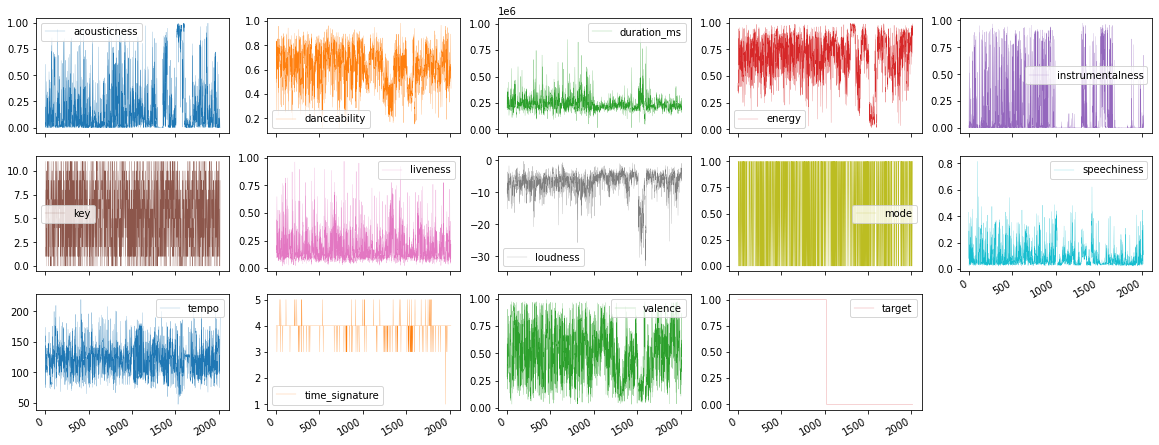

In [43]:
df.plot(subplots=True, legend=True, figsize=(20,8), layout=(3, 5), linewidth=0.2)
plt.show()

* Observando el último gráfico vemos que los atributos están agrupados según el valor de `target` (primer mitad: `target = 1`, segunda mitad: `target = 0`)
* Teniendo en cuenta esto, y mirando el resto de los atributos, se ve a simple vista que algunos están correlacionados con el valor de `target`. Por ejemplo, la primer mitad de `duration_ms` tiene valores un poco más altos que la segunda (el sujeto preferiría canciones más largas). Lo mismo se ve en el atributo `instrumentalness` y en menor medida en `speechiness`

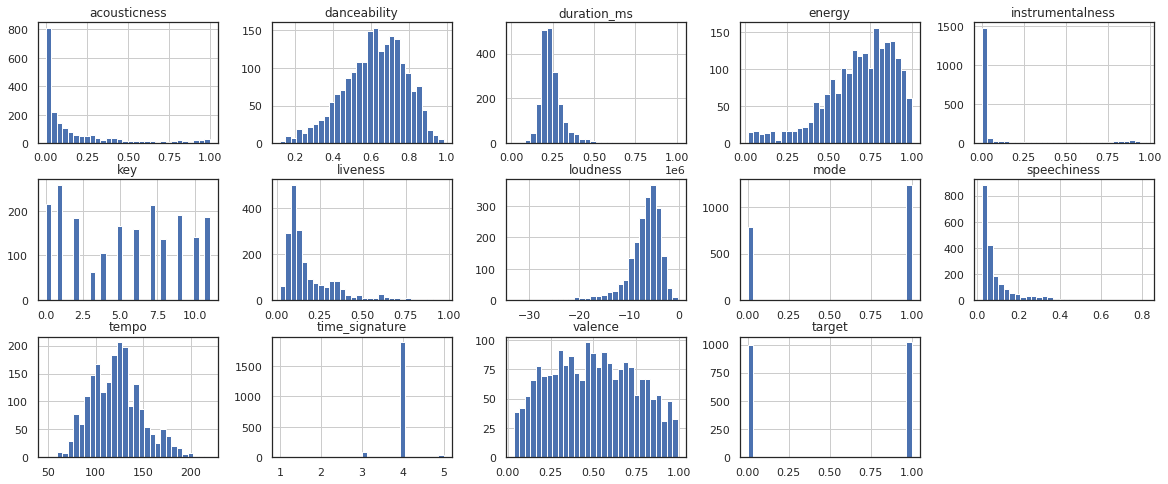

In [54]:
df.hist(figsize = (20,8), bins=30, layout=(3, 5))
plt.show()

* En los histogramas vemos que la mayoría de los atributos estń en el rango `[0,1]`.
* Algunos atributos tienen una distribución de tipo gaussiana (`danceability`, `duration_ms`, `energy`, `liveness`, `loudness`, `tempo`), otros una exponencial decreciente (`acousticness`, `speechiness`) y otros no siguen una distribución reconocible (`key`)

## Analizo la correlación entre los atributos

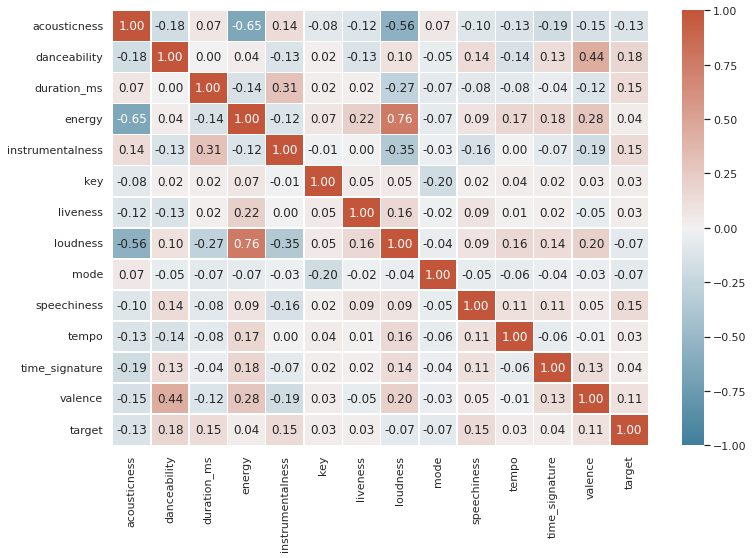

In [5]:
corr = df.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=False, linewidths=.5, annot=True, fmt='0.2f')

* Se puede ver que los atributos en general no están muy correlacionados, con excepción por ejemplo de `energy` y `loudness` con una correlación positiva de `0.76`, o `energy` y `acousticness` con una correlación negativa de `-0.65`.


## Ya que la mayoría de los atributos está acotados al intervalo `[0,1]`, normalizo los atributos que no están contenidos en dicho intervalo

In [5]:
df_norm = df.copy()
min_max_scaler = preprocessing.MinMaxScaler()
df_norm[:] = min_max_scaler.fit_transform(df_norm[:])

## Hago validación cruzada, variando los hiperparámetros:
* Número de vecinos para K-NN
* El método para pesar los puntos (uniforme o según la distancia al punto a evaluar) 
* La cantidad de componentes principales a utilizar

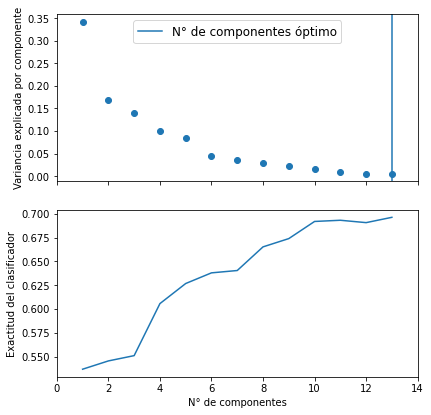

In [62]:
# Barajo las filas del dataset
df_norm = df_norm.sample(frac=1).reset_index(drop=True)

# Divido el dataset en entrenamiento/testeo
data = df_norm.loc[:, df_norm.columns != 'target']
labels = df_norm['target'].values
x_train, x_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,random_state=1)

# Usando el conjunto de entrenamiento, hago validación cruzada

# Primero creo el pipeline 
pca = PCA()
pipe = Pipeline(steps=[('pca', pca),
                       ('knn', KNeighborsClassifier())])
'''
Considero los siguientes hiperparámetros: 
- número de vecinos
- el método para pesar los puntos (uniforme o según la distancia al punto a evaluar) 
- la cantidad de componentes principales a utilizar
'''
param_grid = [{'knn__n_neighbors': [7,9,11,13,15,17,19,21],
           'pca__n_components': [1,2,3,4,5,6,7,8,9,10,11,12,13],
         'knn__weights': ['uniform', 'distance']}]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='accuracy')
search.fit(x_train, y_train)

# Grafico el rango de las componentes principales
pca.fit(x_train)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, 'o', linewidth=2)
ax[0].set_ylabel('Variancia explicada por componente')


ax[0].axvline(search.best_estimator_.named_steps['pca'].n_components,
              label='N° de componentes óptimo')
ax[0].legend(prop=dict(size=12))

# Grafico la exactitud del clasificador para cada número de componentes
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score',
               legend=False, ax=ax[1])
ax[1].set_ylabel('Exactitud del clasificador')
ax[1].set_xlabel('N° de componentes')

plt.xlim(0, 14)

plt.tight_layout()
plt.show()

Al aplicar PCA no se reduce la dimensionalidad (el score no deja de aumentar al agregar componentes), y el mejor resultado se obtiene con una cantidad de componentes igual a la cantidad de atributos del dataset. Esto indica que los atributos del dataset no están muy correlacionados, lo cual concuerda con el hecho de que en la matriz de correlación la mayoría de los elementos son cercanos a 0.

In [64]:
print(list(search.best_params_)[0], ':' ,search.best_params_[list(search.best_params_)[0]])
print(list(search.best_params_)[1], ':' ,search.best_params_[list(search.best_params_)[1]])
print(list(search.best_params_)[2], ':' ,search.best_params_[list(search.best_params_)[2]])

accuracy = search.score(x_test, y_test)
print('Exactitud con el conjunto de testeo: %0.3f' % accuracy)

knn__n_neighbors : 11
knn__weights : distance
pca__n_components : 13
Exactitud con el conjunto de testeo: 0.728


* Usando `11` vecinos pesados según la distancia, y utilizando `13` componentes principales, se obtiene el resultado óptimo.
* Con estos hiperparámetros, la exactitud del clasificador con el conjunto de testeo es de `0.728`